In [38]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

In [2]:
# Device Selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    torch.cuda.empty_cache()

Using device: cuda
GPU Name: NVIDIA GeForce GTX 1650 Ti
GPU Memory: 4.00 GB


In [3]:
# Hyperparameters
EPOCHS = 20
BACTH_SIZE = 64
LR =0.001
NUM_CLASSES = 10

In [4]:
# Download and transform data
trasform_train = transforms.Compose([
    transforms.RandomCrop(32, 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trasform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=trasform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=trasform_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Dataloaders
train_dataloader = DataLoader(train_data, batch_size=BACTH_SIZE, shuffle=True, num_workers=6, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BACTH_SIZE, shuffle=True, num_workers=6, pin_memory=True)
print("Dataset Loaded")

Dataset Loaded


In [6]:
# Model Architecture
def generate_model():
    model = nn.Sequential(
        # CNN Blocks
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), # o/p 64, 16, 16

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), # o/p 128, 8, 8 

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), # o/p 128, 4, 4

        # Classifer Dense Layer
        nn.Flatten(),
        nn.Dropout(),
        nn.Linear(128*4*4, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, NUM_CLASSES)
    )

    return model

In [7]:
# View Model
model = generate_model().to(device=device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [8]:
# Total Params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable params: {total_params}")

Total trainable params: 2960330


In [12]:
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
# Training Loop & Evaluation
print("Starting training...")

start_time = time.time()
loss_over_epochs_train = []
loss_over_epochs_test = []
epoch_list = []

for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0
    running_loss_test = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        op = model(images)                 # forward pass
        loss = loss_fn(op, labels)         # calculate loss

        optimizer.zero_grad()              # Set grad to zero
        loss.backward()                    # Calc grads wrt loss
        optimizer.step()                   # perform weights update

        running_loss += loss.item()
        _, predicted = torch.max(op.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_dataloader)}], '
                   f'Loss: {loss.item():.4f}')
            
    scheduler.step()                       # update LR

    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_acc = 100 * correct_train / total_train
    loss_over_epochs_train.append(epoch_train_loss)
    epoch_list.append(epoch + 1)
    print(f"Epoch [{epoch+1}/{EPOCHS}] completed. Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")


    # Evaluation
    model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            running_loss_test += loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        running_loss_test = running_loss_test / len(test_dataloader)
        loss_over_epochs_test.append(running_loss_test)
        test_acc = 100 * correct_test / total_test
        print(f'Test Accuracy of the model on the {total_test} test images: {test_acc:.2f}%')

print(f"Training finished in {((time.time() - start_time)/60):.2f} mins")

Starting training...
Epoch [1/20], Step [100/782], Loss: 1.8781
Epoch [1/20], Step [200/782], Loss: 1.5818
Epoch [1/20], Step [300/782], Loss: 1.4853
Epoch [1/20], Step [400/782], Loss: 1.3870
Epoch [1/20], Step [500/782], Loss: 1.3297
Epoch [1/20], Step [600/782], Loss: 1.1467
Epoch [1/20], Step [700/782], Loss: 1.0612
Epoch [1/20] completed. Train Loss: 1.4754, Train Acc: 45.69%
Test Accuracy of the model on the 10000 test images: 60.73%
Epoch [2/20], Step [100/782], Loss: 1.2230
Epoch [2/20], Step [200/782], Loss: 1.3569
Epoch [2/20], Step [300/782], Loss: 1.0299
Epoch [2/20], Step [400/782], Loss: 1.2311
Epoch [2/20], Step [500/782], Loss: 0.8447
Epoch [2/20], Step [600/782], Loss: 0.9162
Epoch [2/20], Step [700/782], Loss: 0.8936
Epoch [2/20] completed. Train Loss: 1.0147, Train Acc: 63.71%
Test Accuracy of the model on the 10000 test images: 64.77%
Epoch [3/20], Step [100/782], Loss: 0.8751
Epoch [3/20], Step [200/782], Loss: 0.9643
Epoch [3/20], Step [300/782], Loss: 0.9816
Epoc

In [ ]:
# Save model
torch.save(model.state_dict(), "./CIFAR10_CNN.pth")

In [17]:
# Load model
saved_model = generate_model()
saved_model.load_state_dict(torch.load("./CIFAR10_CNN.pth"))
model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

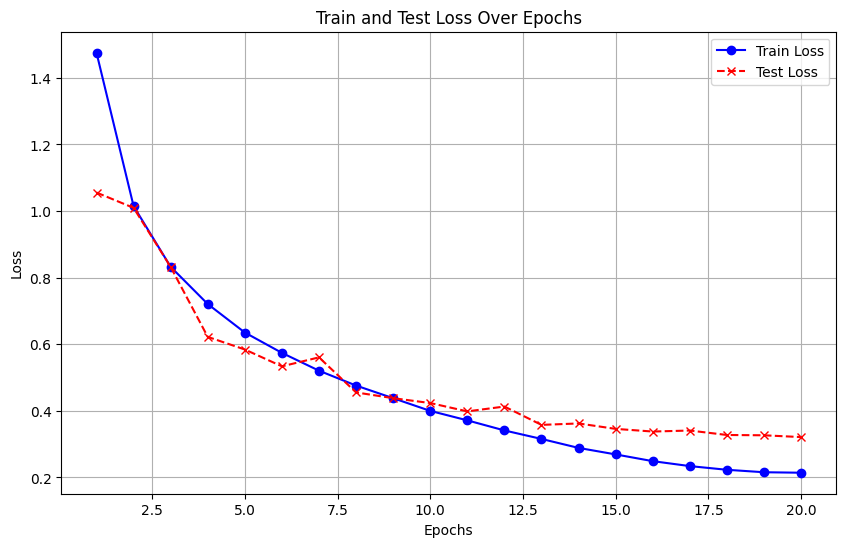

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(epoch_list, loss_over_epochs_train, marker='o', linestyle='-', color='blue', label='Train Loss')
plt.plot(epoch_list, [t.cpu().item() for t in loss_over_epochs_test], marker='x', linestyle='--', color='red', label='Test Loss')

plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)

plt.show()